## Importing all the necessary packages

In [1]:
#Loading data
import pandas as pd
#Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#Text processing
import nltk
from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
#Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
#Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#### *Setting the seed for consistent randomness* 

In [2]:
seed=7

## Loading and structuring the data

In [3]:
dataset=pd.read_csv("/kaggle/input/spamdataset/SMSSpamCollection.txt",sep='\t')
dataset.to_csv("dataset.csv",index=False)
#Data Loading
messages = [line.rstrip() for line in open('dataset.csv')]
print(len(messages))
#Appending column headers
messages = pd.read_csv('dataset.csv',names=["label", "message"])

5574


#### **Data Analysis of our dataset** 

In [4]:

data_size=messages.shape
print(data_size)
messages_col_names = list(messages.columns)
print(messages_col_names)
print(messages.groupby('label').describe())
print(messages.head(2))

(5572, 2)
['label', 'message']
      message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...


#### **Downloading required nltk corpus/packages**

In [5]:
nltk.data.path.append('/path/to/nltk_data')
nltk.download('wordnet', force=True)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### **Visualizing the data by word cloud of text data before preprocessing**

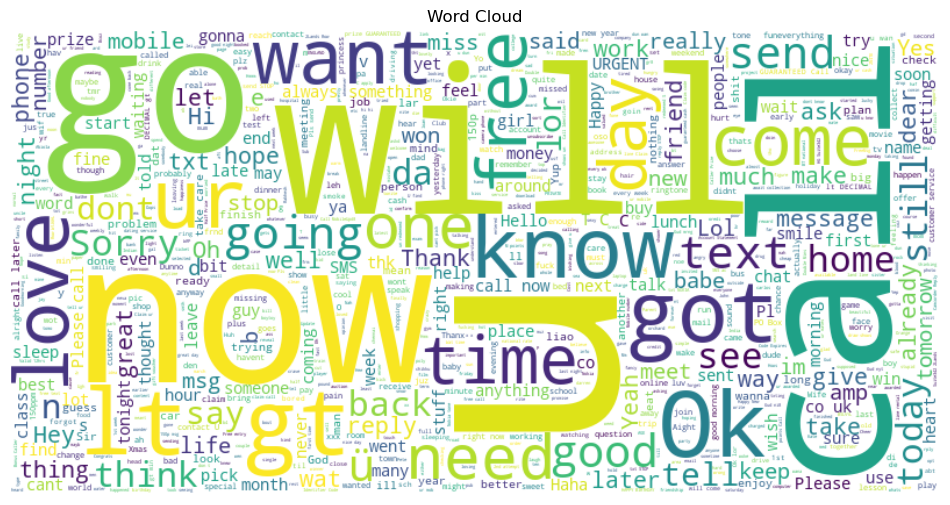

In [6]:
text = " ".join(list(messages['message']))
wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=len(text), contour_width=3, contour_color='steelblue').generate(text)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud")
plt.show()

#### Function for splitting the text into tokens 

In [7]:

def split_tokens(message):
    '''Function to split messages into tokens with the help of nltk module'''
    message = message.lower()
    word_tokens = word_tokenize(message)
    return word_tokens

In [8]:

"""def split_into_lemmas(message):
    lemma = []
    lemmatizer = WordNetLemmatizer()
    for word in message:
        a = lemmatizer.lemmatize(word)
        lemma.append(a)
    return lemma"""

'def split_into_lemmas(message):\n    lemma = []\n    lemmatizer = WordNetLemmatizer()\n    for word in message:\n        a = lemmatizer.lemmatize(word)\n        lemma.append(a)\n    return lemma'

#### Function for removing stopwords from tokenized data

In [9]:

def stopword_removal(message):
    stop_words = set(stopwords.words('english'))
    filter_sentence = []
    filter_sentence = ' '.join([word for word in message if word not in stop_words])
    return filter_sentence



#### Applying preprocessing to the dataset

In [10]:

messages['Tokenized_message'] = messages.apply(lambda row: split_tokens(row['message']), axis=1)
#messages['Lemmatized_message'] = messages.apply(lambda row: split_into_lemmas(row['Tokenized_message']), axis=1)
messages['preprocessed_message'] = messages.apply(lambda row: stopword_removal(row['Tokenized_message']), axis=1)

#### **Visualizing the data by word cloud of text data after preprocessing**

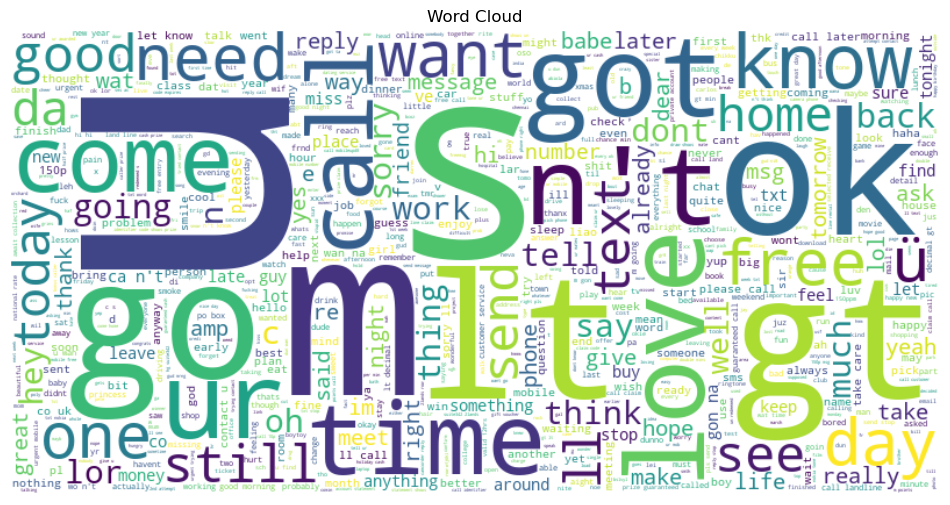

In [11]:
text = " ".join(list(messages['preprocessed_message']))
wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=len(text), contour_width=3, contour_color='steelblue').generate(text)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud")
plt.show()

#### Setting up training data 

In [12]:

Training_data = pd.Series(list(messages['preprocessed_message']), dtype=str)
Training_label = pd.Series(list(messages['label']), dtype=str)

#### Creating BOW with Word Count Vectors

In [13]:

tf_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=(1/len(Training_label)), max_df= 0.7)
Total_Dictionary_TDM = tf_vectorizer.fit(Training_data)
message_data_TDM = Total_Dictionary_TDM.transform(Training_data)


#### Creating BOW with TFIDF Vectors

In [14]:

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=(1/len(Training_label)), max_df=0.7)
Total_Dictionary_TFIDF = tfidf_vectorizer.fit(Training_data)
message_data_TFIDF =Total_Dictionary_TFIDF.transform(Training_data)


#### Spliting dataset into Train and test data/labels

In [15]:
train_data, test_data, train_label, test_label = train_test_split(message_data_TDM, Training_label, test_size=0.1)

#### **Classifying and predicting with Decision Tree Classifier** 

In [16]:

classifier1 = DecisionTreeClassifier()
classifier1 = classifier1.fit(train_data, train_label)
message_predicted_target = classifier1.predict(test_data)
score1 = classifier1.score(test_data, test_label)
print('Decision Tree Classifier : ', score1)
print('Confusion Matrix',confusion_matrix(test_label,message_predicted_target))
target_names = ['spam', 'ham']
print(classification_report(test_label, message_predicted_target, target_names=target_names))

Decision Tree Classifier :  0.982078853046595
Confusion Matrix [[477   4]
 [  6  71]]
              precision    recall  f1-score   support

        spam       0.99      0.99      0.99       481
         ham       0.95      0.92      0.93        77

    accuracy                           0.98       558
   macro avg       0.97      0.96      0.96       558
weighted avg       0.98      0.98      0.98       558



#### **Classifying and predicting with Stochastic Gradient Descent Classifier** 

In [17]:

classifier2 = SGDClassifier(loss='modified_huber', shuffle=True,random_state=seed)
classifier2 = classifier2.fit(train_data, train_label)
score2 = classifier2.score(test_data, test_label)
print('SGD classifier : ',score2)
print('Confusion Matrix',confusion_matrix(test_label,message_predicted_target))
target_names = ['spam', 'ham']
print(classification_report(test_label, message_predicted_target, target_names=target_names))

SGD classifier :  0.978494623655914
Confusion Matrix [[477   4]
 [  6  71]]
              precision    recall  f1-score   support

        spam       0.99      0.99      0.99       481
         ham       0.95      0.92      0.93        77

    accuracy                           0.98       558
   macro avg       0.97      0.96      0.96       558
weighted avg       0.98      0.98      0.98       558



#### **Classifying and predicting with Support Vector Classifier** 

In [18]:

classifier3 = SVC(kernel="linear", C=0.025,random_state=seed)
classifier3 = classifier3.fit(train_data, train_label)
score3 = classifier3.score(test_data, test_label)
print('SVM Classifier : ',score3)
print('Confusion Matrix',confusion_matrix(test_label,message_predicted_target))
target_names = ['spam', 'ham']
print(classification_report(test_label, message_predicted_target, target_names=target_names))

SVM Classifier :  0.982078853046595
Confusion Matrix [[477   4]
 [  6  71]]
              precision    recall  f1-score   support

        spam       0.99      0.99      0.99       481
         ham       0.95      0.92      0.93        77

    accuracy                           0.98       558
   macro avg       0.97      0.96      0.96       558
weighted avg       0.98      0.98      0.98       558



#### **Classifying and predicting with Random Forest Classifier** 

In [19]:

classifier4 = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=10,random_state=seed)
classifier4 = classifier4.fit(train_data, train_label)
score4 = classifier4.score(test_data, test_label)
print('Random Forest Classifier : ',score4)
print('Confusion Matrix',confusion_matrix(test_label,message_predicted_target))
target_names = ['spam', 'ham']
print(classification_report(test_label, message_predicted_target, target_names=target_names))

Random Forest Classifier :  0.8620071684587813
Confusion Matrix [[477   4]
 [  6  71]]
              precision    recall  f1-score   support

        spam       0.99      0.99      0.99       481
         ham       0.95      0.92      0.93        77

    accuracy                           0.98       558
   macro avg       0.97      0.96      0.96       558
weighted avg       0.98      0.98      0.98       558



#### Splitting the training Data StratifiedSuffleSplit to get same percent of labels in both Test and Train data

In [20]:
###cross validation with 10% sample size
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.1, random_state=seed)
sss.get_n_splits(message_data_TDM,Training_label)
print(sss)

StratifiedShuffleSplit(n_splits=1, random_state=7, test_size=0.1,
            train_size=None)


#### Creating a list of classifiers to test on StratifiedShuffleSplit data

In [21]:
classifiers = [
    DecisionTreeClassifier(),
    SGDClassifier(loss='modified_huber', shuffle=True),
    SVC(kernel="linear", C=0.025),
    KNeighborsClassifier(),
    OneVsRestClassifier(svm.LinearSVC()),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=10),
   ]

#### **Results of Different Classifiers on StratifiedShuffleSplit data**

In [22]:
for clf in classifiers:
    score=0
    for train_index, test_index in sss.split(message_data_TDM,Training_label):
       X_train, X_test = message_data_TDM [train_index], message_data_TDM [test_index]
       y_train, y_test = Training_label[train_index], Training_label[test_index]
       clf.fit(X_train, y_train)
       score=score+clf.score(X_test, y_test)
    print(score)


0.9731182795698925
0.96415770609319
0.9659498207885304
0.9014336917562724
0.9731182795698925
0.8655913978494624
